In [1]:
import math
import torch
from diffusion_edf.dist import sample_igso3

from matplotlib import pyplot as plt

In [2]:
sample_w_max = sample_igso3(eps=100., N=100000)
sample_w_max = torch.acos(sample_w_max[:,0])*2
sample_w_degree_max = sample_w_max / torch.pi * 180.

$IG_{SO(3)}$ almost converges at $t=6$

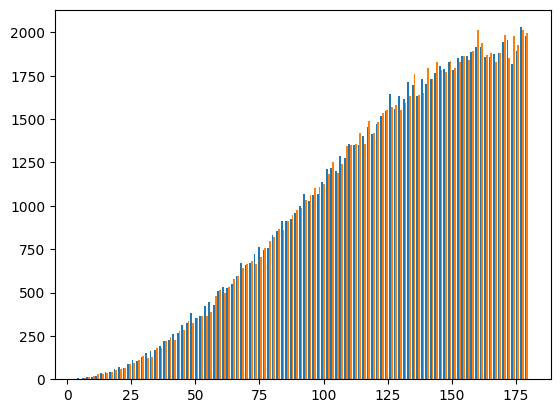

In [3]:
t = 6.
eps = t/2

sample = sample_igso3(eps=eps, N=100000)
sample_w = torch.acos(sample[:,0])*2
sample_w_degree = sample_w / torch.pi * 180.

plt.hist([sample_w_degree, sample_w_degree_max], bins=100)
plt.show()

$\textrm{rotation angle}\ \  w\approx \sqrt{t}\times 38.5\degree$

In [4]:
for t in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
    eps = t/2

    sample = sample_igso3(eps=eps, N=100000)
    sample_w = torch.acos(sample[:,0])*2
    sample_w_degree = sample_w / torch.pi * 180.
    print(sample_w.std().item() / math.sqrt(t))
print(f"\n degree: {sample_w_degree.std().item() / math.sqrt(t)}")

0.672826603573621
0.6750412435889855
0.6735836030630316
0.6759659752315785
0.6745349867913758

 degree: 38.64800787705862


# Play

tensor(3.8561, dtype=torch.float64)


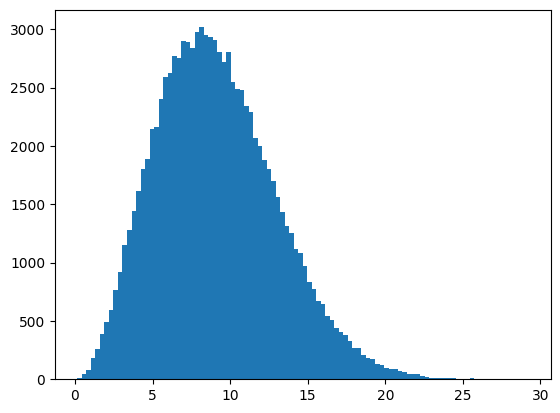

In [5]:
t = 1e-2
eps = t/2

sample = sample_igso3(eps=eps, N=100000)
sample_w = torch.acos(sample[:,0])*2
sample_w_degree = sample_w / torch.pi * 180.
print(sample_w_degree.std())

plt.hist(sample_w_degree, bins=100)
plt.show()

# Calculator

In [6]:
def std_calculator(t_schedule, lin_mult, ang_mult = 1., p = 0.95, N = 100000):
    lin_stds = []
    ang_stds = []
    lin_maxs = []
    ang_maxs = []
    lin_meds = []
    ang_meds = []
    lin_mods = []
    ang_mods = []

    for t in t_schedule:
        eps = t/2 * (ang_mult**2)
        std = torch.tensor([math.sqrt(t*3)]) * lin_mult
        lin_stds.append(std)
        lin_samples = torch.randn(N,3).norm(dim=-1) * std

        sample = sample_igso3(eps=eps, N=N)
        sample_w = torch.acos(sample[:,0])*2
        sample_w_degree = sample_w / torch.pi * 180.
        ang_stds.append(sample_w_degree.std().unsqueeze(0))
        ang_max = sample_w_degree.sort().values[int(p*N)]
        ang_maxs.append(ang_max.unsqueeze(0))
        lin_max = lin_samples.sort().values[int(p*N)]
        lin_maxs.append(lin_max.unsqueeze(0))

        lin_meds.append(lin_samples.median().unsqueeze(0))
        ang_meds.append(sample_w_degree.median().unsqueeze(0))

        boundaries = torch.linspace(0., ang_max*1.2, steps=100)
        bins = torch.bucketize(sample_w_degree, boundaries=boundaries)
        ang_mod = boundaries[bins.mode().values]

        boundaries = torch.linspace(0., lin_max*1.2, steps=100)
        bins = torch.bucketize(lin_samples, boundaries=boundaries)
        lin_mod = boundaries[bins.mode().values]

        lin_mods.append(lin_mod.unsqueeze(0))
        ang_mods.append(ang_mod.unsqueeze(0))

    return torch.cat(lin_stds), torch.cat(ang_stds), torch.cat(lin_maxs), torch.cat(ang_maxs), torch.cat(lin_meds), torch.cat(ang_meds), torch.cat(lin_mods), torch.cat(ang_mods)

In [17]:
lin_stds, ang_stds, lin_maxs, ang_maxs, lin_meds, ang_meds, lin_mods, ang_mods = std_calculator([1e-4, 1e-3, 1e-2, 1e-1, 1.], ang_mult = 2.5, lin_mult=20., p=0.95)

print(f"angular std: {ang_stds}")
print(f"angular median: {ang_meds}")
print(f"angular mode: {ang_mods}")
print(f"angular max: {ang_maxs}")
print("========================================")
print(f"linear std: {lin_stds}")
print(f"linear median: {lin_meds}")
print(f"linear mode: {lin_mods}")
print(f"linear max: {lin_maxs}")

angular std: tensor([ 0.9653,  3.0449,  9.5838, 29.5203, 37.0417], dtype=torch.float64)
angular median: tensor([  2.1960,   6.9569,  21.9571,  67.9685, 132.0526], dtype=torch.float64)
angular mode: tensor([  1.9390,   6.2613,  21.7416,  61.0112, 174.2541])
angular max: tensor([  3.9991,  12.5990,  39.8596, 122.7663, 175.3166], dtype=torch.float64)
linear std: tensor([ 0.3464,  1.0954,  3.4641, 10.9545, 34.6410])
linear median: tensor([ 0.5326,  1.6878,  5.3172, 16.8858, 53.4005])
linear mode: tensor([ 0.4702,  1.4130,  4.5789, 15.5904, 50.4113])
linear max: tensor([ 0.9699,  3.0678,  9.6860, 30.6241, 96.7194])


In [24]:
lin_stds, ang_stds, lin_maxs, ang_maxs, lin_meds, ang_meds, lin_mods, ang_mods = std_calculator([1e-4, 3e-3, 3e-2, 1e-1, 1.], ang_mult = 2.5, lin_mult=20., p=0.95)

print(f"angular std: {ang_stds}")
print(f"angular median: {ang_meds}")
print(f"angular mode: {ang_mods}")
print(f"angular max: {ang_maxs}")
print("========================================")
print(f"linear std: {lin_stds}")
print(f"linear median: {lin_meds}")
print(f"linear mode: {lin_mods}")
print(f"linear max: {lin_maxs}")

angular std: tensor([ 0.9668,  5.2716, 16.5832, 29.6646, 37.1627], dtype=torch.float64)
angular median: tensor([  2.2014,  12.0272,  37.8386,  67.8363, 132.0004], dtype=torch.float64)
angular mode: tensor([  2.0893,  10.8422,  36.6198,  67.3200, 178.7230])
angular max: tensor([  4.0085,  21.8165,  68.6621, 123.4200, 175.5315], dtype=torch.float64)
linear std: tensor([ 0.3464,  1.8974,  6.0000, 10.9545, 34.6410])
linear median: tensor([ 0.5328,  2.9183,  9.2050, 16.8408, 53.2094])
linear mode: tensor([ 0.5045,  2.6344,  8.1137, 15.9891, 46.8930])
linear max: tensor([ 0.9680,  5.3009, 16.7346, 30.6767, 96.7168])
